# **Titanic - Machine Learning from Disaster - MainModel**

このノートブックでは、  
Kaggleコンペティション「Titanic - Machine Learning from Disaster」のデータセットを使用し、  
EDA・特徴量エンジニアリング・モデル改善を含めたメインモデルの構築を行っております。  
  

ベースラインモデルの結果を踏まえ、本ノートブックでは以下のステップを通して精度向上を目指しております:   
- データの可視化と洞察(EDA)
- 有効な特徴量の抽出・生成
- 複数モデルの比較と選定
- ハイパーパラメータチューニングによる最適化  

より高い精度の実現と、より深いデータ理解を目指し、学びながら丁寧に進めております。

## モジュールの読み込み

In [1]:
import os
from pathlib import Path
from glob import glob
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
# from sklearn.metrics import classification_report
# import lightgbm as lgb
# from lightgbm import LGBMClassifier

! pip install catboost

from catboost import CatBoostClassifier
from catboost import Pool

import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.2 MB/s eta 0:00:00


## データの読み込み(kaggle.jsonで読み込む)

In [2]:
# kaggle.jsonのアップロード
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akimasa6637","key":"8510f9e17e9efcce531d3750fbc4a0ee"}'}

In [3]:
# kaggle.json用のフォルダ作成
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# アクセス権限の許可
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Pathの設定
path = Path(".")
data_path = path / "data"
input_path = data_path / "input"
output_path = data_path / "output"

# フォルダの作成
input_path.mkdir(parents=True, exist_ok=True)
output_path.mkdir(parents=True, exist_ok=True)

In [5]:
# データセットのダウンロード
!kaggle competitions download -c titanic -p {input_path}
# titanic.zipの解凍
!unzip {input_path}/titanic.zip -d {input_path}
# titanic.zipの削除
!rm {input_path}/titanic.zip

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 97.3MB/s]
Archive:  data/input/titanic.zip
  inflating: data/input/gender_submission.csv  
  inflating: data/input/test.csv     
  inflating: data/input/train.csv    


In [6]:
# csvpathの取得
csv_list = sorted(glob(f"{input_path}/*.csv"))

# csvの読み込み
train = pd.read_csv(csv_list[2])
test = pd.read_csv(csv_list[1])
submission = pd.read_csv(csv_list[0])

# 配列の要素数の確認
print(train.shape, test.shape, submission.shape)

(891, 12) (418, 11) (418, 2)


## データの確認

In [7]:
# datasetの作成
dataset = pd.concat([train, test], sort=False)
df = dataset.copy()

# dfの確認
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
# 各カラムのdtypeの確認
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [9]:
# 詳細なデータの確認(numberカラム)
df.describe(include=np.number)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [10]:
# 詳細なデータの確認(objectカラム)
df.describe(exclude=np.number)

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Kelly, Mr. James",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


## データの可視化(EDA)

In [11]:
# ヒストグラムによる可視化の定義
def show_histplot(df, cols, n_cols=3):
    n_rows = len(df.columns) / n_cols
    n_rows = math.ceil(n_rows)

    plt.figure(figsize=(n_cols*5, n_rows*3))
    sns.set_style("whitegrid")

    for i, col in enumerate([col for col in cols if col not in "Survived"], 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df[df["Survived"] == 1][col], bins=30, color="red", alpha=0.4, label="Survived", stat="density")
        sns.histplot(df[df["Survived"] == 0][col], bins=30, color="blue", alpha=0.4, label="Not_Survived", stat="density")
        plt.title(f"Distribution_of_{col.title()}_by_Survived")
        plt.xticks(rotation=90)

        plt.legend()
    plt.tight_layout()
    plt.show()

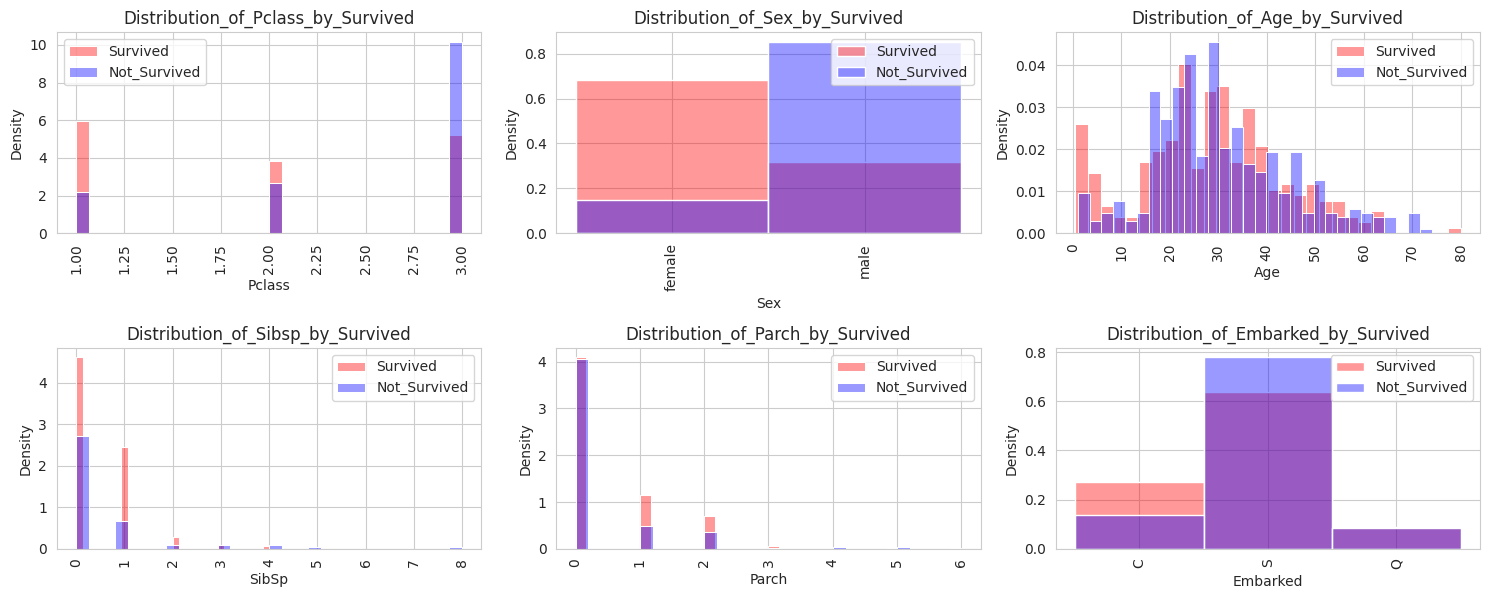

In [12]:
# ヒストグラムによる可視化(hist_colsについては以下にて解説)
hist_cols = ["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Embarked"]
show_histplot(df, hist_cols)

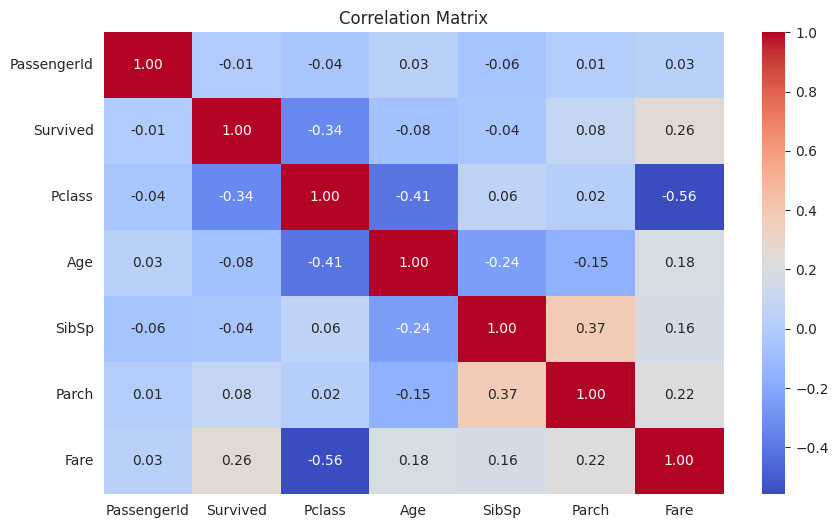

In [13]:
# 相関行列の可視化
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

### EDA結果の考察  
〇 数値・カテゴリ変数の処理(hist_cols)
- PassengerIdはID的役割のため除外
- Name, Ticket, Cabinはユニーク数が多く、直接的な可視化には不向きと判断し、後に加工を検討
- ほかの数値・カテゴリカラムをヒストグラムにて可視化し、分布や偏りを確認
  
〇 生存率と相関の高そうな特徴
- Pclassが1に近いほど生存率が高い
- 性別によって(Sex)生存率に大きな差異がある(女性のほうが生存率が高い)
- 15歳以下の子供(Age)は比較的に生存率が高い
- 兄弟・配偶者(SibSp)の有無が少ないほうが生存率が高い
- 子供を持つ(Parch)ほうが生存率がやや高い
- Embarkedのうち、シェルブールのほうが生存率が高い

〇 仮説  
以上より、 **「裕福さ」「性別」「年齢」** という条件によって、生存率に明確な差が存在しており、  
**お金持ち・女性・子供**といった乗客がタイタニック号沈没の際に、優先的に救助され、生存率が高かったと考察できます。

## 欠損値の前処理

In [14]:
# 欠損値の確認
df.isnull().sum()

,0
PassengerId,0
Survived,418
Pclass,0
Name,0
Sex,0
Age,263
SibSp,0
Parch,0
Ticket,0
Fare,1


In [15]:
# # Cabinの削除(欠損値が多いため)
# df.drop(columns="Cabin", inplace=True)

# 欠損値の処理
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Fare"] = df["Fare"].fillna(df["Fare"].median())
df["Embarked"] = df["Embarked"].fillna("S")

In [16]:
# 再度、欠損値の確認
df.isnull().sum()

,0
PassengerId,0
Survived,418
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


## データの前処理

In [17]:
# 特徴量エンジニアリングの定義
def feature_engineering(df):
    # Cabin より Deck の作成
    df["Deck"] = df["Cabin"].apply(lambda x: str(x)[0])
    df["Deck"] = df["Deck"].fillna("Nan")

    # Ticket より Prefix の作成
    df["Ticket_prefix"] = df["Ticket"].str.extract(r"^([A-Za-z./\s]+)", expand=False).str.strip()
    df["Ticket_prefix"] = df["Ticket_prefix"].fillna("Nan")

    # Sibsp と Parch より Family Size の作成
    df["Family_size"] = df["SibSp"] + df["Parch"] + 1

    # Name より Title の作成
    df["Name_Title"] = df["Name"].str.extract(r",\s*([^\.]*)\s*\.", expand=False).str.strip()

    return df

In [18]:
# 特徴量エンジニアリング
df = feature_engineering(df)

In [19]:
# カテゴリ変換
cat_cols = ["Survived", "Sex", "Embarked", "Pclass", "Deck", "Ticket_prefix", "Name_Title"]
df[cat_cols] = df[cat_cols].astype("category")

In [20]:
# # One Hot Encoding の実施
# ohe_cols = ["Sex", "Embarked", "Pclass", "Deck", "Ticket_prefix"]
# df = pd.get_dummies(df, columns=ohe_cols, dtype=np.int8)

In [21]:
# 特徴量の設定
EX_cols = ["Survived", "PassengerId", "Name", "Ticket", "Cabin"]
FEATURES = [col for col in df.columns if col not in EX_cols]

print(f"説明変数: {FEATURES}")

説明変数: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Deck', 'Ticket_prefix', 'Family_size', 'Name_Title']


In [22]:
# 説明変数の属性の確認
df[FEATURES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Pclass         1309 non-null   category
 1   Sex            1309 non-null   category
 2   Age            1309 non-null   float64 
 3   SibSp          1309 non-null   int64   
 4   Parch          1309 non-null   int64   
 5   Fare           1309 non-null   float64 
 6   Embarked       1309 non-null   category
 7   Deck           1309 non-null   category
 8   Ticket_prefix  1309 non-null   category
 9   Family_size    1309 non-null   int64   
 10  Name_Title     1309 non-null   category
dtypes: category(6), float64(2), int64(3)
memory usage: 71.9 KB


In [23]:
# dfを train と test に再分割(Survivedがnanではない=>train, Survivedがnanである=>test)
train = df[df["Survived"].notnull()]
test = df[df["Survived"].isnull()]

# 配列の要素数の確認
print(train.shape, test.shape)

(891, 16) (418, 16)


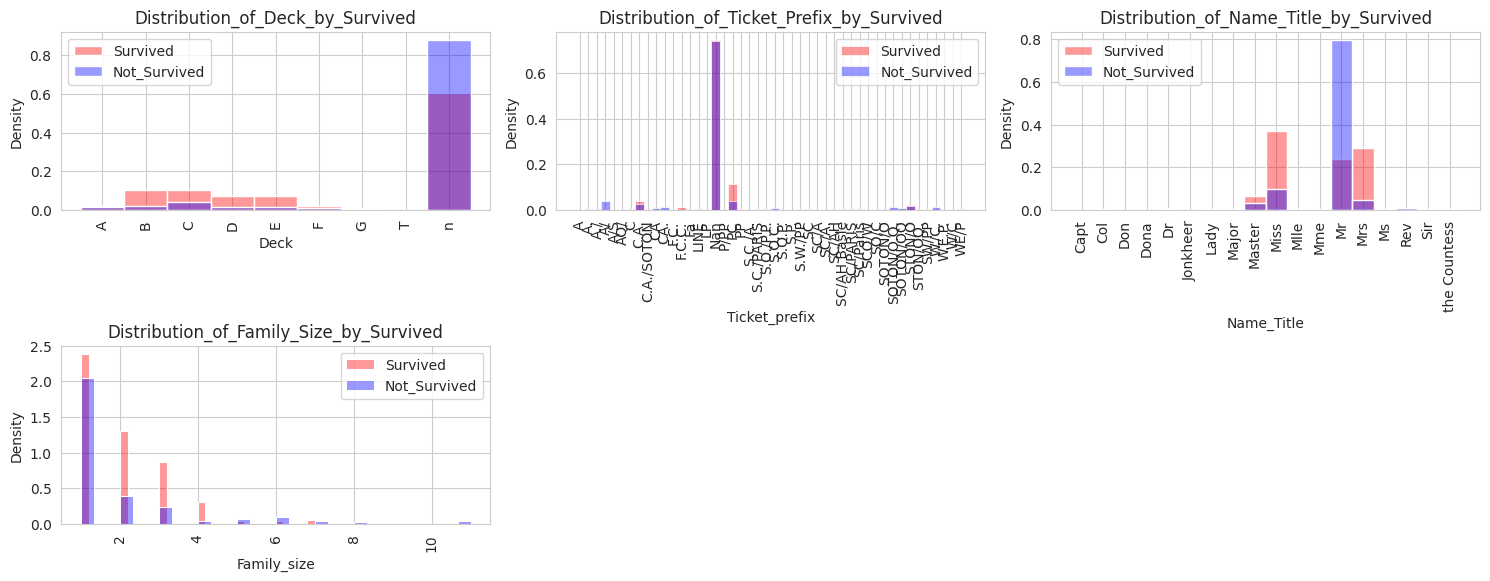

In [24]:
# 作成した特徴量の可視化
hist_cols = ["Survived", "Deck", "Ticket_prefix", "Name_Title", "Family_size"]
show_histplot(df, hist_cols)

## 学習ループ

前処理の結果、カテゴリ変数(離散値)が多く含まれていたため、  
LightGBMから、カテゴリ変数への対応が得意なCatBoostを利用して予測を行います。

In [25]:
# ハイパーパラメータの設定
FOLDS = 3
seed = 42

# 交差検証の設定
cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

# カテゴリ変数のカラムリスト作成
cat_features = train[FEATURES].select_dtypes(include="category").columns.tolist()

In [26]:
# 変数の作成
auc_scores_train = []
auc_scores_valid = []
acc_score = []
imp = pd.DataFrame()
models = []

# 交差検証での学習
for fold, (train_idx, valid_idx) in enumerate(cv.split(train[FEATURES], train["Survived"])):
    print("#"*40)
    print(f"### [FOLD {fold+1}/{FOLDS}]")
    print(f"### train idx: {len(train_idx)}, valid idx{len(valid_idx)}")
    print("#"*40)

    # 各データの分割
    X_train = train.loc[train_idx, FEATURES]
    y_train = train.loc[train_idx, "Survived"]
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, "Survived"]

    # CatBoostのPoolの設定
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

    # モデルの設定
    model = CatBoostClassifier(
        iterations=5000,
        learning_rate=0.03,
        depth=10,
        loss_function="Logloss",
        eval_metric="AUC",
        random_state=seed,
        use_best_model=True,
        verbose=100
    )

    # model = LGBMClassifier(
    #     n_estimators=5000,
    #     learning_rate=0.03,
    #     num_leaves=31,
    #     metrics="auc",
    #     random_state=seed,
    #     verbose=-1
    #     )

    # 学習ループ
    model.fit(
        train_pool,
        eval_set=valid_pool,
        early_stopping_rounds=500,
        verbose=100
    )

    # model.fit(
    #     X_train, y_train,
    #     eval_set=[(X_train, y_train), (X_valid, y_valid)],
    #     callbacks=[
    #         lgb.early_stopping(stopping_rounds=100),
    #         lgb.log_evaluation(10)
    #     ]
    # )

    # ROC AUC Score
    ## 説明変数から目的変数の予測
    pred_train = model.predict_proba(X_train)[:, 1]
    pred_valid = model.predict_proba(X_valid)[:, 1]
    ## 評価
    auc_train = roc_auc_score(y_train, pred_train)
    auc_valid = roc_auc_score(y_valid, pred_valid)

    # Accuracy Score
    ## 説明変数から目的変数の予測
    pred_valid = model.predict(X_valid)
    ## 評価
    acc = accuracy_score(y_valid, pred_valid)

    # 評価結果とモデルの追加
    auc_scores_train.append(auc_train)
    auc_scores_valid.append(auc_valid)
    acc_score.append(acc)
    models.append(model)

    # 重要度のDF作成
    _imp = pd.DataFrame({
        "features": FEATURES,
        "importance": model.feature_importances_,
        "fold": fold+1
    })
    # 重要度の追加
    imp = pd.concat([imp, _imp], axis=0)

    print()

########################################
### [FOLD 1/3]
### train idx: 594, valid idx297
########################################
0:	test: 0.8347234	best: 0.8347234 (0)	total: 64.7ms	remaining: 5m 23s
100:	test: 0.8930112	best: 0.8938261 (81)	total: 4.99s	remaining: 4m 2s
200:	test: 0.9014236	best: 0.9014716 (197)	total: 9.44s	remaining: 3m 45s
300:	test: 0.9055460	best: 0.9055460 (300)	total: 11.7s	remaining: 3m 1s
400:	test: 0.9111543	best: 0.9111543 (399)	total: 17.7s	remaining: 3m 22s
500:	test: 0.9121609	best: 0.9122088 (494)	total: 23s	remaining: 3m 26s
600:	test: 0.9114898	best: 0.9124964 (505)	total: 25.1s	remaining: 3m 3s
700:	test: 0.9131675	best: 0.9134072 (699)	total: 27.1s	remaining: 2m 46s
800:	test: 0.9121609	best: 0.9134072 (699)	total: 30.5s	remaining: 2m 39s
900:	test: 0.9107228	best: 0.9134072 (699)	total: 32.7s	remaining: 2m 28s
1000:	test: 0.9109625	best: 0.9134072 (699)	total: 34.8s	remaining: 2m 19s
1100:	test: 0.9117295	best: 0.9134072 (699)	total: 36.9s	remaini

## 結果と重要度の表示

In [27]:
# ndarray変換
auc_scores_train = np.array(auc_scores_train)
auc_scores_valid = np.array(auc_scores_valid)
acc_score = np.array(acc_score)

# 評価結果の表示
print(f"[ cv] AUC train: {auc_scores_train.mean():.4f}+-{auc_scores_train.std():.4f}, AUC valid: {auc_scores_valid.mean():.4f}+-{auc_scores_valid.std():.4f}, Accuracy score: {acc_score.mean():.4f}+-{acc_score.std():.4f}")

[ cv] AUC train: 0.9330+-0.0322, AUC valid: 0.8832+-0.0218, Accuracy score: 0.8305+-0.0151


In [28]:
# 重要度の平均と標準偏差の作成
imp_df = imp.groupby("features")["importance"].agg(["mean", "std"]).sort_values(by="mean", ascending=False)
imp_df.columns = ["imp", "imp_std"]

# 重要度の表示
imp_df.head(20)

,imp,imp_std
features,,
Sex,23.672148,28.143879
Pclass,14.656338,1.572246
Name_Title,14.544498,4.933222
Age,10.737215,4.623689
Embarked,9.438051,6.825255
Fare,8.288464,5.333506
Deck,6.502559,2.681502
Ticket_prefix,5.177796,4.484316
Family_size,3.869279,0.996012


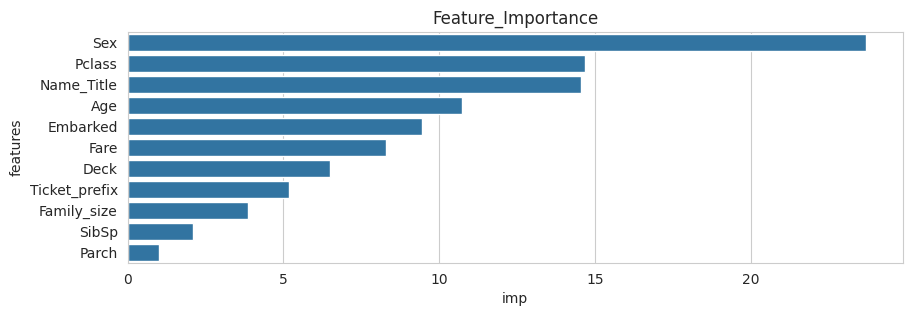

In [29]:
# 重要度の可視化
plt.figure(figsize=(10, 3))
sns.set_style("whitegrid")

sns.barplot(x="imp", y="features", data=imp_df)
plt.title("Feature_Importance")
plt.show()

## 提出ファイルの作成

In [30]:
# 単一モデルによるアンサンブル予測の定義
def models_predict_proba(X, models):
    print(f"n_models: {len(models)}")
    preds = []

    for model in models:
        pred = model.predict_proba(X)[:, 1]
        preds.append(pred)

    preds = np.array(preds)
    preds = np.mean(preds, axis=0)

    return preds

In [31]:
# 説明変数から目的変数の単一アンサンブル予測
y_pred = models_predict_proba(test[FEATURES], models)
# 予測を1か0に変換
y_pred = np.where(y_pred > 0.5, 1, 0)

# 提出ファイルのデータ作成
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": y_pred
})

n_models: 3


In [32]:
# 提出ファイルの作成
submission.to_csv(output_path / "submission_main.csv", index=False)

提出スコア: **0.78708**

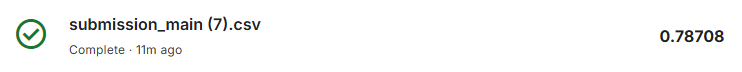

## まとめ

本ノートブックでは、ベースラインモデルを基盤として、  
**EDA・特徴量エンジニアリング・モデル選定・ハイパーパラメータの調整**を通じ、  
より高い精度を目指したモデル改善に取り組みました。  
  
  
特に、詳細なデータ分析と前処理の実施、  
カテゴリ変数の処理に優れたCatBoostの活用により、  
モデルの安定性および特徴量の解釈性を向上させることができました。  


ーーーーー  
### 〇 取り組み内容の概要
- **EDA**:　　　　　　　　　　データ分布や相関関係を可視化し、生存率に要員を与える要因を分析
- **特徴量エンジニアリング**:　EDAで得られた考察をもとに、より詳細な特徴量の作成
- **モデルの選定**:　　　　　　特徴量の特性に応じてモデルを見直し、CatBoostを採用
- **ハイパーパラメータ調整**:　安定性と汎化性能の向上を目的にパラメータを最適化  

ーーーーー  

本ノートブックで得られた知見や学びを活かし、  
今後の課題への取り組みや、より精度の高いモデル構築に向けた改善に活用してまいります。